In [2]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os.path
import matplotlib.pyplot as plt
from catheter import numpy_catheter_mesh_2d , numpy_catheter_mesh_1d


In [3]:
def lineseg_dists(p, a, b):
    """Cartesian distance from point to line segment

    Edited to support arguments as series, from:
    https://stackoverflow.com/a/54442561/11208892

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """
    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

def lineseg_dist(p, a, b): 
    n_p = p.shape[0] 
    n_s = a.shape[0]

    p_s = np.tile(p, (n_s,1))
    a_s = np.tile(a, (1,n_p)).reshape((-1,2))
    b_s = np.tile(b, (1,n_p)).reshape((-1,2))
    
    dists = lineseg_dists(p_s, a_s, b_s)
    dists = dists.reshape((-1, n_p)).reshape((-1, n_p))
    dists = np.min(dists, axis=0)
    
    return dists


# Generate 1D surface mesh for $x_2$, $x_3$, $h$


Let define $h_c = 20$ and $x_1 = 40$

1. Initial mesh is from $(\frac{x_1 + x_3}{2}, x_3, h)$


2. Deform the mesh from $(\frac{x_1 + x_3}{2}, x_3, h)$ to $(x_2, x_3, h)$
    $$(x, y) \rightarrow (x + \Delta x, y)$$
    
* For the points $x \in [x_1, \frac{x_1 + x_3}{2}] \qquad y \in [0, h]$ 
    
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{x - 0}{\frac{x_1  + x_3}{2}\frac{y}{h} + (1 - \frac{y}{h})x_1}  \frac{y}{h} \Delta x_{max} $$
       

* For the points $x \in [\frac{x_1 + x_3}{2}, x_3] \qquad y \in [0, h]$ 
    
    $$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{L_x - x}{(L_x - \frac{x_1  + x_3}{2})\frac{y}{h} + (1 - \frac{y}{h})(L_x - x_3)}  \frac{y}{h} \Delta x_{max} $$
       
    
Overall, the formula can be written as 

$$ \Delta x_{max} = x_2 - \frac{x_1 + x_3}{2} \qquad \Delta x = \frac{dx}{(dx_1)dy + (h - dy)(dx_2)}  dy \Delta x_{max} $$
        
```
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
```

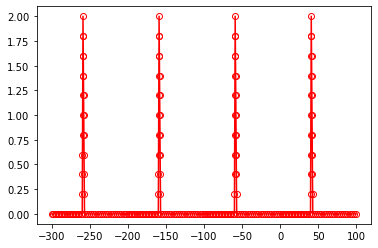

In [6]:
from catheter import numpy_catheter_mesh_1d

x1, x2, x3, h = 40, 10, 50, 5
ncy = 20
ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
ncx = ncx1 + ncx2 + ncx3 + ncx4

n_periods = 4
x_mesh, y_mesh = np.zeros(n_periods*ncx+1), np.zeros(n_periods*ncx+1)

x2, x3, h = 41, 43, 2             
X, Y = numpy_catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4, plot_or_not = False)

x_mesh[-(ncx + 1):], y_mesh[-(ncx + 1):] = X, Y    
for i_period in range(1,n_periods):
    x_mesh[-((i_period + 1)*ncx + 1):-(i_period*ncx)], y_mesh[-((i_period + 1)*ncx + 1):-(i_period*ncx)] = X - 100*i_period, Y

plt.figure()
plt.plot(x_mesh, y_mesh, "-or", fillstyle="none")

In [8]:
ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
ncx = ncx1 + ncx2 + ncx3 + ncx4
n_periods = 4

ndata = len(range(41,60,2))*len(range(41,60,2))*len(np.arange(2,6.6,0.5))
x_mesh, y_mesh = np.zeros((n_periods*ncx+1, ndata)), np.zeros((n_periods*ncx+1, ndata))

pref_folder = "/groups/esm/dzhuang/Catheter/"
ind = 0
for x2 in range(41,60,2):
    for x3 in range(41,60,2):
        for h in np.arange(2,6.6,0.5):
            
            
            X, Y = numpy_catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4, plot_or_not = False)
            
            x_mesh[-(ncx + 1):, ind], y_mesh[-(ncx + 1):, ind] = X, Y    
            for i_period in range(1,n_periods):
                x_mesh[-((i_period + 1)*ncx + 1):-(i_period*ncx), ind], y_mesh[-((i_period + 1)*ncx + 1):-(i_period*ncx), ind] = X - 100*i_period, Y
                
            ind += 1
            
np.save(pref_folder+"x_1d_structured_mesh.npy",   x_mesh)
np.save(pref_folder+"y_1d_structured_mesh.npy",   y_mesh)
